<a href="https://colab.research.google.com/github/puzis/llmnet/blob/main/experiments/Distil_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

In [ ]:
from transformers import AutoTokenizer, DistilBertModel, DistilBertConfig
import torch
import torch.nn as nn
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
dataset = load_dataset("glue", "mrpc")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokens = tokenizer(dataset['train']['sentence1'][:15], truncation=True, padding="longest", return_tensors="pt")

In [ ]:
dataset = load_dataset("Amod/mental_health_counseling_conversations")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokens = tokenizer(dataset['train']['Response'][:5], truncation=True, padding="longest", return_tensors="pt")

In [ ]:
dataset = load_dataset("tweet_eval", "sentiment")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokens = tokenizer(dataset['train']['text'][:15], truncation=True, padding="max_length", return_tensors="pt")

In [ ]:
class SA_LayerNorm(nn.Module):
    def __init__(self, hidden_size):
        super(SA_LayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, x):
        return self.layer_norm(x)

class DistilBERT(nn.Module):
    def __init__(self, model_name_or_path="distilbert-base-uncased"):
        super(DistilBERT, self).__init__()
        self.config = DistilBertConfig.from_pretrained(model_name_or_path)
        self.distilbert = DistilBertModel.from_pretrained(model_name_or_path, config=self.config)

        # Adding SA_LayerNorm head for each transformer layer
        self.sa_layer_norms = nn.ModuleList([SA_LayerNorm(self.config.dim) for _ in range(self.config.num_hidden_layers)])

    def forward(self, input_ids, attention_mask=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state

        embedding_output = hidden_states

        k_values, v_values, q_values, out_lin_output, ffn_output, output_layer_norm, sa_layer_norm_output = [], [], [], [], [], [], []
        all_hidden_states = [hidden_states]

        for i, layer in enumerate(self.distilbert.transformer.layer):
            k_values.append(layer.attention.k_lin(hidden_states))
            v_values.append(layer.attention.v_lin(hidden_states))
            q_values.append(layer.attention.q_lin(hidden_states))

            out_lin_output.append(layer.attention.out_lin(hidden_states))

            ffn_out = layer.ffn(hidden_states)
            ffn_output.append(ffn_out)

            hidden_states = layer.output_layer_norm(ffn_out + hidden_states)
            output_layer_norm.append(hidden_states)

            # Applying SA_LayerNorm to the last hidden state for each transformer layer
            sa_layer_norm_output.append(self.sa_layer_norms[i](hidden_states))

            all_hidden_states.append(hidden_states)

        # Concatenate outputs along dim=0
        concatenated_output = torch.cat([
            embedding_output,
        ], dim=0)

        for i in range(len(self.distilbert.transformer.layer)):
            concatenated_output = torch.cat([
                concatenated_output,
                k_values[i],
                v_values[i],
                q_values[i],
                out_lin_output[i],
                output_layer_norm[i],
                sa_layer_norm_output[i],
                ffn_output[i]
            ], dim=0)

          # Delete variables after use
        del k_values[i], v_values[i], q_values[i], out_lin_output[i], output_layer_norm[i], sa_layer_norm_output[i], ffn_output[i], hidden_states


        return concatenated_output

In [ ]:
with torch.no_grad():
  model = DistilBERT()
  tensor = torch.empty(0)
  output = model(**tokens)
  output = output.reshape(768*43, len(tokens['input_ids'][1])*15)

In [5]:
def corrcoef(input):
    rowvar = False
    dim = 0 if rowvar else 1
    tensor = input - input.mean(dim=dim, keepdim=True)
    norm = (tensor * tensor).sum(dim=dim, keepdim=True).sqrt()
    corr = (tensor @ tensor.t()) / norm / norm.t()
    del tensor, norm
    return corr.squeeze()

In [6]:
corr = corrcoef(output)

In [7]:
del dataset
del model
del output
del tensor
del tokenizer
del tokens

In [8]:
corr[corr < 0.5] = 0

In [9]:
corr_matrix_np = corr.numpy()
del corr

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix_np, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
degree = torch.sum(corr, dim=0)
degree = degree.detach().numpy()

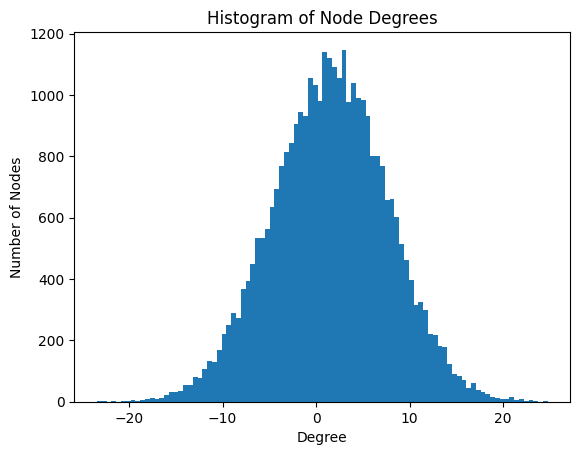

In [ ]:
plt.hist(degree, bins='auto')
plt.title('Histogram of Node Degrees')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.show()

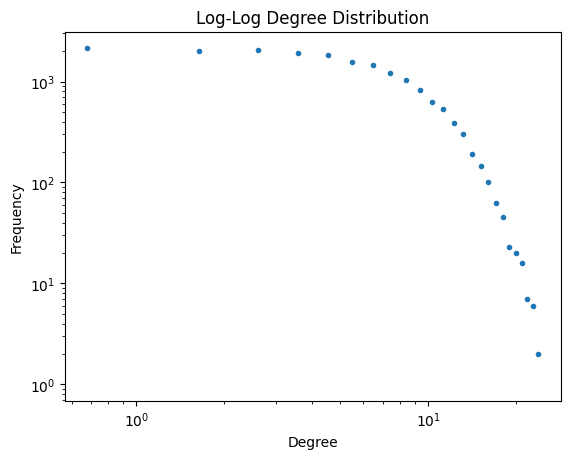

In [ ]:
import numpy as np
# Plotting histogram on log-log scale
counts, bins = np.histogram(degree, bins=50)
plt.loglog(bins[:-1], counts, '.')
plt.title('Log-Log Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

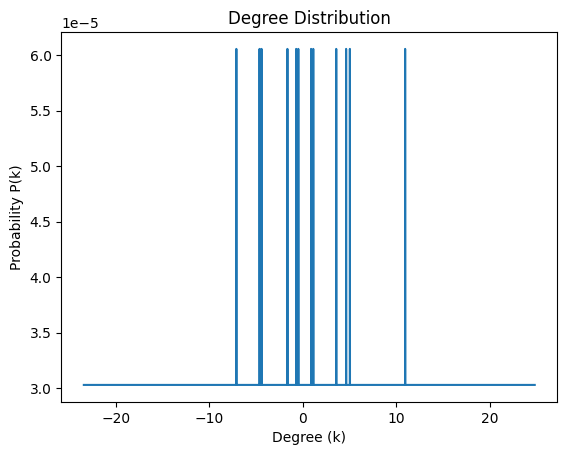

In [ ]:
# Calculate degree by summing the adjacency matrix row-wise
degree = torch.sum(corr, dim=1)

# Calculate the probability distribution
unique, counts = torch.unique(degree, return_counts=True)
prob = counts.float() / degree.shape[0]

# Plot degree distribution
plt.plot(unique.numpy(), prob.numpy())
plt.title('Degree Distribution')
plt.xlabel('Degree (k)')
plt.ylabel('Probability P(k)')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

# Convert the correlation matrix to numpy
correlation_matrix_np = corr.numpy()

# Apply KMeans
kmeans = KMeans(n_clusters=2).fit(correlation_matrix_np)

# Get cluster labels
labels = kmeans.labels_

In [ ]:
labels